In [1]:
%%capture
!pip install pyspark

In [2]:
import json
import sys
import time
import random

import pandas as pd
import pyspark.sql.functions as f
import pyspark.sql.types as t

from datetime import datetime, timedelta
from operator import add
from functools import reduce
from fractions import Fraction
from typing import Tuple, Optional, Iterator
from pprint import pprint
from sklearn.linear_model import LinearRegression
from py4j.protocol import Py4JJavaError

from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.utils import AnalysisException
from pyspark.sql.window import Window

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
spark = (
    SparkSession
    .builder
    .appName("app")
    .getOrCreate()
)
# методы rdd находятся в объекте sparkContext
sc = spark.sparkContext
spark.sparkContext.setLogLevel("WARN")

читаем данные. их проблема в том, что каждый паркет файл может содержать разный набор колонок. Чтобы избежать ошибок при чтении, используем unionByName. Данная команда объединяет строки df. Уникальные колонки будут содержать пропуски там, где их не было

In [6]:
gsod = (
    spark.read.parquet('/content/gdrive/MyDrive/Colab Notebooks/pyspark/ch10_window/files/gsod_light.parquet')
    .dropna(subset=["year", "mo", "da", "temp"])
    .where(f.col("temp") != 9999.9)
    .drop("date")
    .select('stn', 'year', 'mo', 'da', 'temp', 'count_temp')
)
gsod.show(5)

+------+----+---+---+----+----------+
|   stn|year| mo| da|temp|count_temp|
+------+----+---+---+----+----------+
|994979|2017| 12| 11|21.3|        21|
|998012|2017| 03| 02|31.4|        24|
|719200|2017| 10| 09|60.5|        11|
|917350|2018| 04| 21|82.6|         9|
|076470|2018| 06| 07|65.0|        24|
+------+----+---+---+----+----------+
only showing top 5 rows



#### Оконные ф-ии

задача - найти станцию, месяц, день, когда была зарегистрирована самая минимальная температура в году

решение без оконных

In [ ]:
coldest_temp = (
    gsod
    .groupby('year')
    .agg(f.min(f.col('temp')).alias('temp'))
)
coldest_temp.orderBy('temp').show()

(
    gsod
    .join(coldest_temp, on=['temp', 'year'], how='left_semi')
).show()

+----+----+
|year|temp|
+----+----+
|2019|16.1|
|2017|21.3|
|2018|55.6|
+----+----+

+----+----+------+---+---+----------+
|temp|year|   stn| mo| da|count_temp|
+----+----+------+---+---+----------+
|21.3|2017|994979| 12| 11|        21|
|55.6|2018|996470| 03| 12|        12|
|16.1|2019|041680| 02| 19|        15|
+----+----+------+---+---+----------+



решение с оконными  
оконные ф-ии позволяют упростить код и избавиться от дорогой операции - соединение df с самим собой  
в pyspark термин партиции иммеет 2 значения:  
1 - физическое разделение данных на каждом узле-исполнителе  
2 - логическое разбиение данных в соответствии с заданной оконной ф-ией  
физические партиции скорее всего не будут ссответсвовать логическим

результат создания окна - объект WindowSpec, который содержит информацию о параметрах окна  
c помощью метода withColumn мы создаем колонку, которая содержит минимальную температуру для каждого года такого же размера как исходный df  
метод over заставляет ф-ию min примениться не ко всему df, а к каждому окну (партиции нашей ф-ии)  
это применимо к любым агрегирующим ф-им pyspark, например  sum(), avg(),
min(), max(), count()

In [ ]:
each_year = Window.partitionBy("year")
print(each_year)

(
    gsod
    .withColumn('min_temp', f.min('temp').over(each_year))
    .filter('temp == min_temp')
    .orderBy("year", "mo", "da")
).show()

+------+----+---+---+----+----------+--------+
|   stn|year| mo| da|temp|count_temp|min_temp|
+------+----+---+---+----+----------+--------+
|994979|2017| 12| 11|21.3|        21|    21.3|
|996470|2018| 03| 12|55.6|        12|    55.6|
|041680|2019| 02| 19|16.1|        15|    16.1|
+------+----+---+---+----+----------+--------+



#### Ранжирование на оконных ф-иях

ф-ия rank присваивает непоследовательный ранг для каждой записи в окне.  
при использовании rank одинаковым элементам будет присвоен одинаковый ранг  
если имеется два элемента с рангом 1, то после них будет следовать элемент с рангом 3

In [ ]:
temp_per_month_asc = (
    Window.partitionBy("mo")
    .orderBy("count_temp")
)

(
    gsod.withColumn(
        "rank_tpm", f.rank().over(temp_per_month_asc)
    )
).show()

+------+----+---+---+----+----------+--------+
|   stn|year| mo| da|temp|count_temp|rank_tpm|
+------+----+---+---+----+----------+--------+
|041680|2019| 02| 19|16.1|        15|       1|
|996470|2018| 03| 12|55.6|        12|       1|
|998166|2019| 03| 20|34.8|        12|       1|
|998012|2017| 03| 02|31.4|        24|       3|
|917350|2018| 04| 21|82.6|         9|       1|
|998252|2019| 04| 18|44.7|        11|       2|
|076470|2018| 06| 07|65.0|        24|       1|
|719200|2017| 10| 09|60.5|        11|       1|
|949110|2019| 11| 23|54.9|        14|       1|
|994979|2017| 12| 11|21.3|        21|       1|
+------+----+---+---+----+----------+--------+



dense_rank() - логика такая же, но между рангами нет разрыва, то есть они идут последовательно

In [ ]:
(
    gsod.withColumn(
        "rank_tpm", f.dense_rank().over(temp_per_month_asc)
    )
).show()

+------+----+---+---+----+----------+--------+
|   stn|year| mo| da|temp|count_temp|rank_tpm|
+------+----+---+---+----+----------+--------+
|041680|2019| 02| 19|16.1|        15|       1|
|996470|2018| 03| 12|55.6|        12|       1|
|998166|2019| 03| 20|34.8|        12|       1|
|998012|2017| 03| 02|31.4|        24|       2|
|917350|2018| 04| 21|82.6|         9|       1|
|998252|2019| 04| 18|44.7|        11|       2|
|076470|2018| 06| 07|65.0|        24|       1|
|719200|2017| 10| 09|60.5|        11|       1|
|949110|2019| 11| 23|54.9|        14|       1|
|994979|2017| 12| 11|21.3|        21|       1|
+------+----+---+---+----+----------+--------+



percent_rank выводит порядковую позицию в долях, где минимум - это 0, а максимум - это 1

In [ ]:
# each_year - наше окно, партицированное по годам
temp_each_year = each_year.orderBy("temp")
gsod.withColumn(
    "rank_tpm", f.percent_rank().over(temp_each_year)
).show()


+------+----+---+---+----+----------+------------------+
|   stn|year| mo| da|temp|count_temp|          rank_tpm|
+------+----+---+---+----+----------+------------------+
|994979|2017| 12| 11|21.3|        21|               0.0|
|998012|2017| 03| 02|31.4|        24|               0.5|
|719200|2017| 10| 09|60.5|        11|               1.0|
|996470|2018| 03| 12|55.6|        12|               0.0|
|076470|2018| 06| 07|65.0|        24|               0.5|
|917350|2018| 04| 21|82.6|         9|               1.0|
|041680|2019| 02| 19|16.1|        15|               0.0|
|998166|2019| 03| 20|34.8|        12|0.3333333333333333|
|998252|2019| 04| 18|44.7|        11|0.6666666666666666|
|949110|2019| 11| 23|54.9|        14|               1.0|
+------+----+---+---+----+----------+------------------+



ntile разобьет ранжирование по группам  
если оконная партиция не делится на равные группы, то последняя будет немного меньше остальных

In [ ]:
gsod.withColumn("rank_tpm", f.ntile(2).over(temp_each_year)).show()

+------+----+---+---+----+----------+--------+
|   stn|year| mo| da|temp|count_temp|rank_tpm|
+------+----+---+---+----+----------+--------+
|994979|2017| 12| 11|21.3|        21|       1|
|998012|2017| 03| 02|31.4|        24|       1|
|719200|2017| 10| 09|60.5|        11|       2|
|996470|2018| 03| 12|55.6|        12|       1|
|076470|2018| 06| 07|65.0|        24|       1|
|917350|2018| 04| 21|82.6|         9|       2|
|041680|2019| 02| 19|16.1|        15|       1|
|998166|2019| 03| 20|34.8|        12|       1|
|998252|2019| 04| 18|44.7|        11|       2|
|949110|2019| 11| 23|54.9|        14|       2|
+------+----+---+---+----+----------+--------+



row_number просто пронумерует элементы оконной пратиции

In [ ]:
gsod.withColumn("rank_tpm", f.row_number().over(temp_each_year)).show()

+------+----+---+---+----+----------+--------+
|   stn|year| mo| da|temp|count_temp|rank_tpm|
+------+----+---+---+----+----------+--------+
|994979|2017| 12| 11|21.3|        21|       1|
|998012|2017| 03| 02|31.4|        24|       2|
|719200|2017| 10| 09|60.5|        11|       3|
|996470|2018| 03| 12|55.6|        12|       1|
|076470|2018| 06| 07|65.0|        24|       2|
|917350|2018| 04| 21|82.6|         9|       3|
|041680|2019| 02| 19|16.1|        15|       1|
|998166|2019| 03| 20|34.8|        12|       2|
|998252|2019| 04| 18|44.7|        11|       3|
|949110|2019| 11| 23|54.9|        14|       4|
+------+----+---+---+----+----------+--------+



окно по убыванию

In [ ]:
temp_per_month_desc = (
    Window.partitionBy("mo").orderBy(
        f.col("count_temp").desc()
    )
)
gsod.withColumn(
    "row_number", f.row_number().over(temp_per_month_desc)
).show()

+------+----+---+---+----+----------+----------+
|   stn|year| mo| da|temp|count_temp|row_number|
+------+----+---+---+----+----------+----------+
|041680|2019| 02| 19|16.1|        15|         1|
|998012|2017| 03| 02|31.4|        24|         1|
|996470|2018| 03| 12|55.6|        12|         2|
|998166|2019| 03| 20|34.8|        12|         3|
|998252|2019| 04| 18|44.7|        11|         1|
|917350|2018| 04| 21|82.6|         9|         2|
|076470|2018| 06| 07|65.0|        24|         1|
|719200|2017| 10| 09|60.5|        11|         1|
|949110|2019| 11| 23|54.9|        14|         1|
|994979|2017| 12| 11|21.3|        21|         1|
+------+----+---+---+----+----------+----------+



#### Аналитика на оконных ф-иях

ф-ия lag создаст колонку со сдвигом по каждой оконной партиции    
каждой записи будет соответсвовать пердыдущая с заданным шагом  
ф-ия lead - тоже самая, но для каждой записи соответсвует следующая

In [ ]:
(
    gsod
    .withColumn(
        "previous_temp", f.lag("temp").over(temp_each_year)
    ).withColumn(
        "previous_temp_2", f.lag("temp", 2).over(temp_each_year)
    ).withColumn(
        "next_temp_1", f.lead("temp", 1).over(temp_each_year)
    )
).show()

+------+----+---+---+----+----------+-------------+---------------+
|   stn|year| mo| da|temp|count_temp|previous_temp|previous_temp_2|
+------+----+---+---+----+----------+-------------+---------------+
|994979|2017| 12| 11|21.3|        21|         NULL|           31.4|
|998012|2017| 03| 02|31.4|        24|         21.3|           60.5|
|719200|2017| 10| 09|60.5|        11|         31.4|           NULL|
|996470|2018| 03| 12|55.6|        12|         NULL|           65.0|
|076470|2018| 06| 07|65.0|        24|         55.6|           82.6|
|917350|2018| 04| 21|82.6|         9|         65.0|           NULL|
|041680|2019| 02| 19|16.1|        15|         NULL|           34.8|
|998166|2019| 03| 20|34.8|        12|         16.1|           44.7|
|998252|2019| 04| 18|44.7|        11|         34.8|           54.9|
|949110|2019| 11| 23|54.9|        14|         44.7|           NULL|
+------+----+---+---+----+----------+-------------+---------------+



кумулятивная дистанция  
формула - количество записей, которые болше или равны текущей / общее количество записей

In [ ]:
(
    gsod
    .withColumn(
        "cume_dist", f.cume_dist().over(temp_each_year)
    )
).show()

+------+----+---+---+----+----------+------------------+
|   stn|year| mo| da|temp|count_temp|         cume_dist|
+------+----+---+---+----+----------+------------------+
|994979|2017| 12| 11|21.3|        21|0.3333333333333333|
|998012|2017| 03| 02|31.4|        24|0.6666666666666666|
|719200|2017| 10| 09|60.5|        11|               1.0|
|996470|2018| 03| 12|55.6|        12|0.3333333333333333|
|076470|2018| 06| 07|65.0|        24|0.6666666666666666|
|917350|2018| 04| 21|82.6|         9|               1.0|
|041680|2019| 02| 19|16.1|        15|              0.25|
|998166|2019| 03| 20|34.8|        12|               0.5|
|998252|2019| 04| 18|44.7|        11|              0.75|
|949110|2019| 11| 23|54.9|        14|               1.0|
+------+----+---+---+----+----------+------------------+



 когда порядок не определен, по умолчанию используется неограниченная рамка окна. При определении порядка по умолчанию используется растущая рамка окна.

In [ ]:
not_ordered = Window.partitionBy("year")
ordered = not_ordered.orderBy("temp")

(
    gsod.withColumn(
        "avg_NO", f.avg("temp").over(not_ordered)
    )
    .withColumn("avg_O", f.avg("temp").over(ordered))
).show()

+------+----+---+---+----+----------+------------------+------------------+
|   stn|year| mo| da|temp|count_temp|            avg_NO|             avg_O|
+------+----+---+---+----+----------+------------------+------------------+
|994979|2017| 12| 11|21.3|        21|37.733333333333334|              21.3|
|998012|2017| 03| 02|31.4|        24|37.733333333333334|             26.35|
|719200|2017| 10| 09|60.5|        11|37.733333333333334|37.733333333333334|
|996470|2018| 03| 12|55.6|        12| 67.73333333333333|              55.6|
|076470|2018| 06| 07|65.0|        24| 67.73333333333333|              60.3|
|917350|2018| 04| 21|82.6|         9| 67.73333333333333| 67.73333333333333|
|041680|2019| 02| 19|16.1|        15|            37.625|              16.1|
|998166|2019| 03| 20|34.8|        12|            37.625|             25.45|
|998252|2019| 04| 18|44.7|        11|            37.625|31.866666666666664|
|949110|2019| 11| 23|54.9|        14|            37.625|            37.625|
+------+----

Схема границ на основе строк  

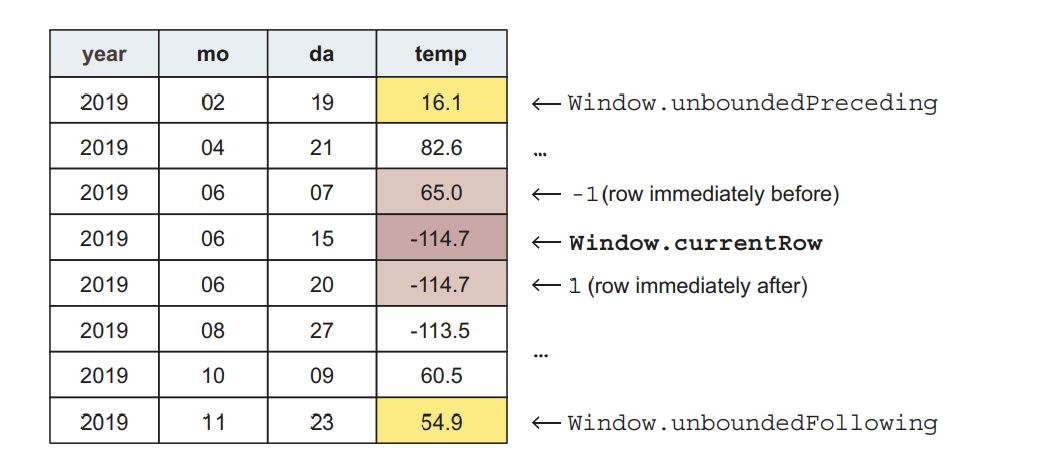

если убрать ограничения окна, то результат с сотировкой будет равен результату без сортировки

In [ ]:
not_ordered = (
    Window.partitionBy("year")
    .rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)
)
ordered = (
    not_ordered.orderBy("temp")
    .rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
)

(
    gsod.withColumn(
        "avg_NO", f.avg("temp").over(not_ordered)
    )
    .withColumn("avg_O", f.avg("temp").over(ordered))
).show()

+------+----+---+---+----+----------+------------------+------------------+
|   stn|year| mo| da|temp|count_temp|            avg_NO|             avg_O|
+------+----+---+---+----+----------+------------------+------------------+
|994979|2017| 12| 11|21.3|        21|37.733333333333334|37.733333333333334|
|998012|2017| 03| 02|31.4|        24|37.733333333333334|37.733333333333334|
|719200|2017| 10| 09|60.5|        11|37.733333333333334|37.733333333333334|
|996470|2018| 03| 12|55.6|        12| 67.73333333333333| 67.73333333333333|
|076470|2018| 06| 07|65.0|        24| 67.73333333333333| 67.73333333333333|
|917350|2018| 04| 21|82.6|         9| 67.73333333333333| 67.73333333333333|
|041680|2019| 02| 19|16.1|        15|            37.625|            37.625|
|998166|2019| 03| 20|34.8|        12|            37.625|            37.625|
|998252|2019| 04| 18|44.7|        11|            37.625|            37.625|
|949110|2019| 11| 23|54.9|        14|            37.625|            37.625|
+------+----

границы окна на основе диапазона.  
испоьзуется, когда окно может быть плавающего размера  
например если окно отранжировано по дате и на одну дату будет 2 наблюдения, то граница на основе строк будет работать неправильно

схема границ на основе диапазона
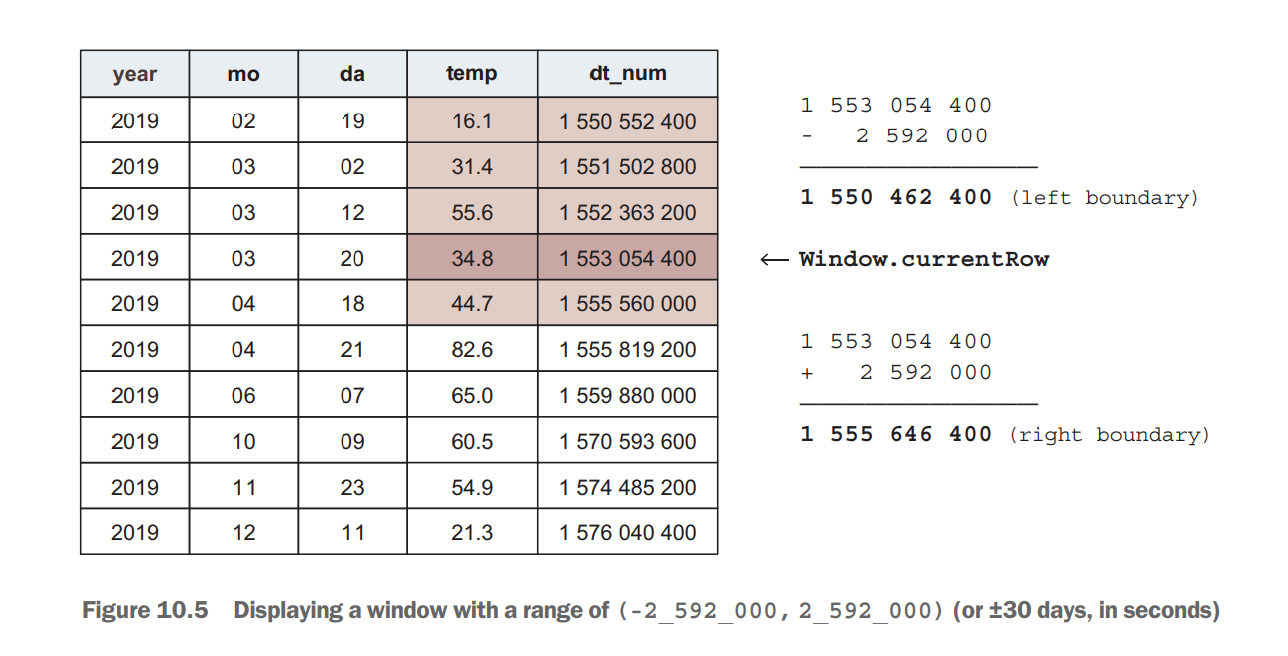

создаем колонку с датой в числовом представлении

In [ ]:
gsod_p = (
    gsod
    .withColumn("year", f.lit(2019))
    .withColumn(
        "dt",
        f.to_date(
            f.concat_ws("-", f.col("year"), f.col("mo"), f.col("da"))
        ),
    )
    .withColumn("dt_num", f.unix_timestamp("dt"))
)
gsod_p.show()

+------+----+---+---+----+----------+----------+----------+
|   stn|year| mo| da|temp|count_temp|        dt|    dt_num|
+------+----+---+---+----+----------+----------+----------+
|994979|2019| 12| 11|21.3|        21|2019-12-11|1576022400|
|998012|2019| 03| 02|31.4|        24|2019-03-02|1551484800|
|719200|2019| 10| 09|60.5|        11|2019-10-09|1570579200|
|917350|2019| 04| 21|82.6|         9|2019-04-21|1555804800|
|076470|2019| 06| 07|65.0|        24|2019-06-07|1559865600|
|996470|2019| 03| 12|55.6|        12|2019-03-12|1552348800|
|041680|2019| 02| 19|16.1|        15|2019-02-19|1550534400|
|949110|2019| 11| 23|54.9|        14|2019-11-23|1574467200|
|998252|2019| 04| 18|44.7|        11|2019-04-18|1555545600|
|998166|2019| 03| 20|34.8|        12|2019-03-20|1553040000|
+------+----+---+---+----+----------+----------+----------+



чтобы использовать rangeBetween, требуется преобразовать дату в числовой вид, например в секунды

In [ ]:
ONE_MONTH_ISH = 30 * 60 * 60 * 24 # 2_592_000 секунд, примерно месяц
one_month_ish_before_and_after = (
    Window.partitionBy("year")
    .orderBy("dt_num")
    .rangeBetween(-ONE_MONTH_ISH, ONE_MONTH_ISH)
)
gsod_p.withColumn(
    "avg_count", f.avg("count_temp").over(one_month_ish_before_and_after)
).show()

+------+----+---+---+----+----------+----------+----------+------------------+
|   stn|year| mo| da|temp|count_temp|        dt|    dt_num|         avg_count|
+------+----+---+---+----+----------+----------+----------+------------------+
|041680|2019| 02| 19|16.1|        15|2019-02-19|1550534400|             15.75|
|998012|2019| 03| 02|31.4|        24|2019-03-02|1551484800|             15.75|
|996470|2019| 03| 12|55.6|        12|2019-03-12|1552348800|             15.75|
|998166|2019| 03| 20|34.8|        12|2019-03-20|1553040000|              14.8|
|998252|2019| 04| 18|44.7|        11|2019-04-18|1555545600|10.666666666666666|
|917350|2019| 04| 21|82.6|         9|2019-04-21|1555804800|              10.0|
|076470|2019| 06| 07|65.0|        24|2019-06-07|1559865600|              24.0|
|719200|2019| 10| 09|60.5|        11|2019-10-09|1570579200|              11.0|
|949110|2019| 11| 23|54.9|        14|2019-11-23|1574467200|              17.5|
|994979|2019| 12| 11|21.3|        21|2019-12-11|1576

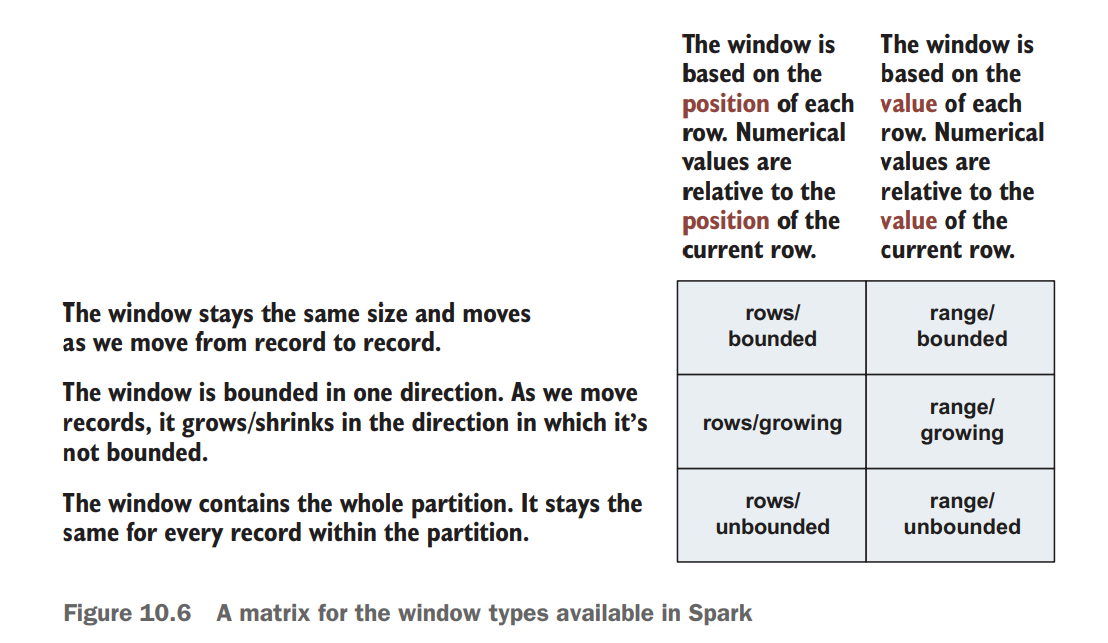

оконные функции + udf  
для примера udf, которая считает медиану  
во второй строке столбца median_temp_g значение 45, так как это медиана между 31.4 и 60.5

In [ ]:
@f.pandas_udf(t.DoubleType())
def median(vals: pd.Series) -> float:
    return vals.median()

(
    gsod
    .withColumn(
        "median_temp", median("temp").over(Window.partitionBy("year"))
    ).withColumn(
        "median_temp_g",
        median("temp").over(
            Window.partitionBy("year").orderBy("mo", "da")
        ),
    )
).show()

+------+----+---+---+----+----------+-----------+-------------+
|   stn|year| mo| da|temp|count_temp|median_temp|median_temp_g|
+------+----+---+---+----+----------+-----------+-------------+
|998012|2017| 03| 02|31.4|        24|       31.4|         31.4|
|719200|2017| 10| 09|60.5|        11|       31.4|        45.95|
|994979|2017| 12| 11|21.3|        21|       31.4|         31.4|
|996470|2018| 03| 12|55.6|        12|       65.0|         55.6|
|917350|2018| 04| 21|82.6|         9|       65.0|         69.1|
|076470|2018| 06| 07|65.0|        24|       65.0|         65.0|
|041680|2019| 02| 19|16.1|        15|      39.75|         16.1|
|998166|2019| 03| 20|34.8|        12|      39.75|        25.45|
|998252|2019| 04| 18|44.7|        11|      39.75|         34.8|
|949110|2019| 11| 23|54.9|        14|      39.75|        39.75|
+------+----+---+---+----+----------+-----------+-------------+



#### задания

убрир  
для каждой даты посчитать сумму чисел в течение 10 дней с ее начала

In [ ]:
date_today = datetime.now()
dates = [(date_today - timedelta(days=x)).date() for x in range(0, 20)]
random_numbers = [random.randint(1, 5) for _ in range(20)]

df = spark.createDataFrame(zip(dates, random_numbers), schema=['Date', 'Random_Number'])
df.orderBy('Date').show()

window = Window().orderBy('Date').rowsBetween(Window.currentRow, 9)
df.withColumn('sum', f.sum('Random_Number').over(window)).show()

+----------+-------------+
|      Date|Random_Number|
+----------+-------------+
|2023-10-15|            3|
|2023-10-16|            5|
|2023-10-17|            2|
|2023-10-18|            3|
|2023-10-19|            3|
|2023-10-20|            3|
|2023-10-21|            5|
|2023-10-22|            2|
|2023-10-23|            3|
|2023-10-24|            1|
|2023-10-25|            5|
|2023-10-26|            4|
|2023-10-27|            3|
|2023-10-28|            3|
|2023-10-29|            1|
|2023-10-30|            5|
|2023-10-31|            5|
|2023-11-01|            3|
|2023-11-02|            5|
|2023-11-03|            3|
+----------+-------------+



создать колонку, в которой True соответсвует объекту с максимальной температурой за 7 дней до и после момента фиксации этой температуры

In [13]:
gsod = (
    reduce(
        lambda x, y: x.unionByName(y, allowMissingColumns=True),
        [
            spark.read.parquet(f"/content/gdrive/MyDrive/Colab Notebooks/pyspark/ch9_pd_udf/files//gsod{year}.parquet")
            for year in range(2019, 2021)
        ],
    )
    .dropna(subset=["year", "mo", "da", "temp"])
    .where(f.col("temp") != 9999.9)
    .select('stn', 'year', 'mo', 'da', 'temp')
    .drop("date")
)

gsod = (
    gsod
    .withColumn(
        "dt",
        f.to_date(
            f.concat_ws("-", f.col("year"), f.col("mo"), f.col("da"))
        ),
    )
    .withColumn("dt_num", f.unix_timestamp("dt"))
)

gsod.show(5)

+------+----+---+---+----+----------+----------+
|   stn|year| mo| da|temp|        dt|    dt_num|
+------+----+---+---+----+----------+----------+
|041680|2019| 02| 19|16.1|2019-02-19|1550534400|
|949110|2019| 11| 23|54.9|2019-11-23|1574467200|
|998252|2019| 04| 18|44.7|2019-04-18|1555545600|
|998166|2019| 03| 20|34.8|2019-03-20|1553040000|
|998482|2019| 06| 17|81.0|2019-06-17|1560729600|
+------+----+---+---+----+----------+----------+
only showing top 5 rows



In [19]:
ONE_WEEK_ISH = 7 * 60 * 60 * 24
dt_temp = (
    Window
    .partitionBy('stn')
    .orderBy('dt_num')
    .rangeBetween(-ONE_WEEK_ISH,ONE_WEEK_ISH)
)

(
    gsod
    .withColumn('max_temp', f.max(f.col('temp'))
    .over(dt_temp))
    .withColumn(
        'flag',
        f.when(f.col('max_temp')==f.col('temp'), True).otherwise(False)
    )
).show(100)

+------+----+---+---+----+----------+----------+--------+-----+
|   stn|year| mo| da|temp|        dt|    dt_num|max_temp| flag|
+------+----+---+---+----+----------+----------+--------+-----+
|010060|2019| 01| 01| 5.2|2019-01-01|1546300800|    21.2|false|
|010060|2019| 01| 02| 4.3|2019-01-02|1546387200|    21.6|false|
|010060|2019| 01| 03|14.2|2019-01-03|1546473600|    22.0|false|
|010060|2019| 01| 04|16.0|2019-01-04|1546560000|    22.0|false|
|010060|2019| 01| 05|18.8|2019-01-05|1546646400|    22.0|false|
|010060|2019| 01| 06|18.9|2019-01-06|1546732800|    22.0|false|
|010060|2019| 01| 07|21.2|2019-01-07|1546819200|    22.0|false|
|010060|2019| 01| 08|16.5|2019-01-08|1546905600|    22.0|false|
|010060|2019| 01| 09|21.6|2019-01-09|1546992000|    22.0|false|
|010060|2019| 01| 10|22.0|2019-01-10|1547078400|    22.0| true|
+------+----+---+---+----+----------+----------+--------+-----+
only showing top 10 rows

